**Covid-19 in Italy. Cases incidence per 100.000 people by region**

**Import libraries**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.offsetbox import AnchoredText

from custom.plot_utils import get_xticks_labels

**Read the csv file provided by Protezione Civile**

- data (index)
- codice_regione = region code
- denominazione_regione = region name
- totale_casi = total cases (cumulative sum)

In [2]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
date_parser = lambda x: pd.to_datetime(x, infer_datetime_format=True)
columns = ["data", "codice_regione", "denominazione_regione", "totale_casi"]
df = pd.read_csv(url,
                 usecols=columns,
                 parse_dates=["data"],
                 date_parser=date_parser,
                 index_col="data")
df = df[df.index >= "2021/09/01"]
df.tail()

,codice_regione,denominazione_regione,totale_casi
data,,,
2022-01-01 17:00:00,19,Sicilia,378368
2022-01-01 17:00:00,9,Toscana,396593
2022-01-01 17:00:00,10,Umbria,92680
2022-01-01 17:00:00,2,Valle d'Aosta,16574
2022-01-01 17:00:00,5,Veneto,659993


**Get regional codes/names**

In [3]:
codes = df["codice_regione"].unique()
regions = df["denominazione_regione"].unique()
reg_dict = dict(zip(codes, regions))
reg_dict

{13: 'Abruzzo',
 17: 'Basilicata',
 18: 'Calabria',
 15: 'Campania',
 8: 'Emilia-Romagna',
 6: 'Friuli Venezia Giulia',
 12: 'Lazio',
 7: 'Liguria',
 3: 'Lombardia',
 11: 'Marche',
 14: 'Molise',
 21: 'P.A. Bolzano',
 22: 'P.A. Trento',
 1: 'Piemonte',
 16: 'Puglia',
 20: 'Sardegna',
 19: 'Sicilia',
 9: 'Toscana',
 10: 'Umbria',
 2: "Valle d'Aosta",
 5: 'Veneto'}

**Get demographic data**

In [4]:
# Read demographic data from the government repository
demo_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-statistici-riferimento/popolazione-istat-regione-range.csv"
df_demo = pd.read_csv(demo_url)
df_demo.tail()

,codice_regione,codice_nuts_1,descrizione_nuts_1,codice_nuts_2,denominazione_regione,sigla_regione,latitudine_regione,longitudine_regione,range_eta,totale_genere_maschile,totale_genere_femminile,totale_generale
205,5,ITH,Nord-Est,ITH3,Veneto,VEN,45.434905,12.338452,50-59,399024,400436,799460
206,5,ITH,Nord-Est,ITH3,Veneto,VEN,45.434905,12.338452,60-69,293238,309972,603210
207,5,ITH,Nord-Est,ITH3,Veneto,VEN,45.434905,12.338452,70-79,228669,265774,494443
208,5,ITH,Nord-Est,ITH3,Veneto,VEN,45.434905,12.338452,80-89,115439,177591,293030
209,5,ITH,Nord-Est,ITH3,Veneto,VEN,45.434905,12.338452,90+,16430,49080,65510


In [5]:
codes_by_nut = df_demo.groupby("descrizione_nuts_1")["codice_regione"].apply(set).reset_index()
codes_by_nut

,descrizione_nuts_1,codice_regione
0,Centro,"{9, 10, 11, 12}"
1,Isole,"{19, 20}"
2,Nord-Est,"{5, 6, 8, 21, 22}"
3,Nord-Ovest,"{1, 2, 3, 7}"
4,Sud,"{13, 14, 15, 16, 17, 18}"


**Plot Covid-19 cases per 100.000, 7-day period**

In [6]:
def plot_cases_per_nut(nut, nrows=2, ncols=2, figsize=(8,8), top=0.925):

      mask = codes_by_nut["descrizione_nuts_1"] == nut
      codes = list(codes_by_nut[mask]["codice_regione"].values[0])

      fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
      title = f"Covid-19 cases per 100.000, 7-day period ({nut})"
      fig.suptitle(title, fontsize=16)
      axes = ax.ravel()

      cmap =  plt.cm.get_cmap("nipy_spectral", 21)

      for i, code in enumerate(codes):

            region = reg_dict[code]
            df_ = df[df["codice_regione"]==code]["totale_casi"].diff()
            pop = df_demo[df_demo["codice_regione"]==code]["totale_generale"].sum()
            rate = df_.rolling(window=7, min_periods=1).sum()/pop*10**5

            color = cmap(i)
            axes[i].plot(df_.index, rate, c=color)
            axes[i].fill_between(x=df_.index, y1=rate, color=color, alpha=0.10)
      
            axes[i].margins(x=0)
            axes[i].set_ylim(0, )

            ticks, labels = get_xticks_labels(df_.index)
            axes[i].set_xticks(ticks)
            axes[i].set_xticklabels(labels)

            at = AnchoredText(f"{region}\n{int(rate[-1])}", frameon=False, loc="upper left")
            axes[i].add_artist(at)
            if len(codes)<nrows*ncols:
                  axes[-1].set_axis_off()
      fig.tight_layout()
      fig.subplots_adjust(top=top)
      plt.show()


**Central Italy**

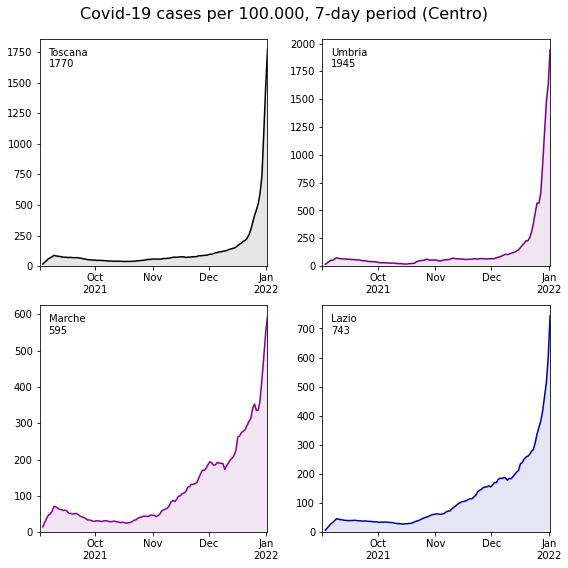

In [7]:
plot_cases_per_nut("Centro")

**Italy Islands**

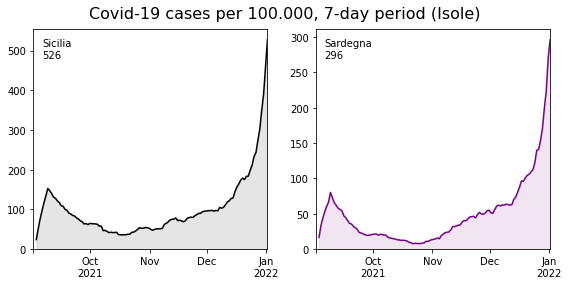

In [8]:
plot_cases_per_nut("Isole", nrows=1, ncols=2, figsize=(8, 4), top=0.90)

**Northeast Italy**

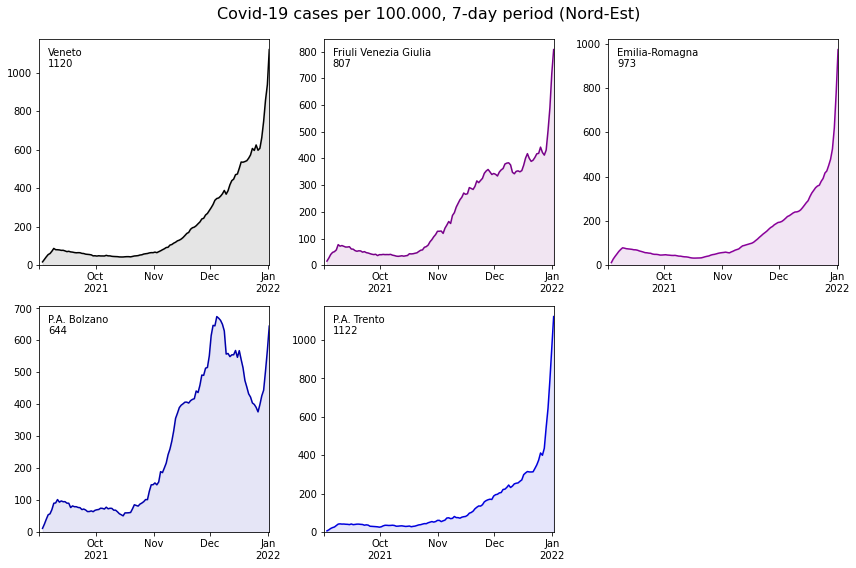

In [9]:
plot_cases_per_nut("Nord-Est", nrows=2, ncols=3, figsize=(12, 8), top=0.925)

**Northwest Italy**

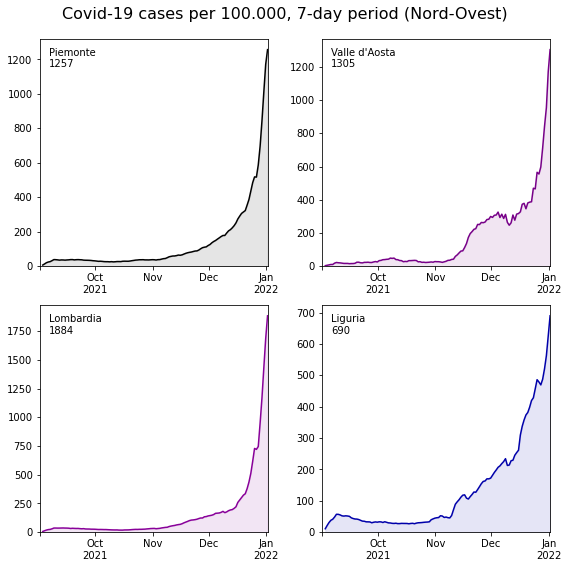

In [10]:
plot_cases_per_nut("Nord-Ovest")

**Southern Italy**

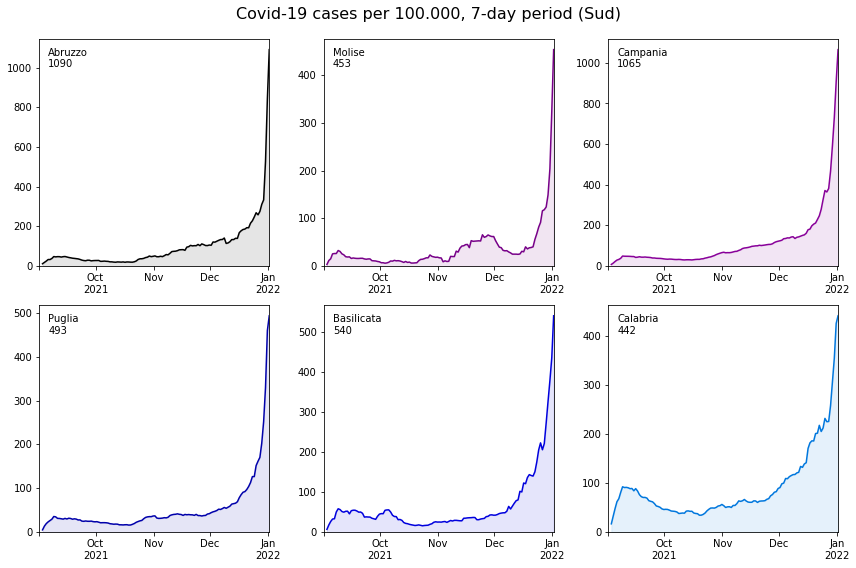

In [11]:
plot_cases_per_nut("Sud", nrows=2, ncols=3, figsize=(12, 8), top=0.925)